In [1]:
import tensorflow as tf
import time
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
class Generator():
    def __init__(self, device_name='/cpu:0'):

        # Generator parameter
        with tf.device(device_name):
            self.gen_w1 = tf.Variable(
                tf.truncated_normal(
                    shape=[100, 128], stddev=0.02, dtype=tf.float32),
                name="gen_w1")
            self.gen_b1 = tf.Variable(
                tf.truncated_normal(shape=[128], stddev=0.02, dtype=tf.float32),
                name="gen_b1")

            self.gen_w2 = tf.Variable(
                tf.truncated_normal([128,256], stddev=0.02, dtype=tf.float32),
                name="gen_w2")
            self.gen_b2 = tf.Variable(
                tf.truncated_normal(
                    shape=[256], stddev=0.02, dtype=tf.float32),
                name="gen_b2")

            self.gen_w3 = tf.Variable(
                tf.truncated_normal([256, 2], stddev=0.02, dtype=tf.float32),
                name="gen_w3")
            self.gen_b3 = tf.Variable(
                tf.truncated_normal(shape=[2], stddev=0.02, dtype=tf.float32),
                name="gen_b3")

            self.keep_prob = tf.placeholder(tf.float32)

    def run(self, z, is_train, device_name='/cpu:0'):

        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(z, self.gen_w1, self.gen_b1), alpha=0.2)

            h2 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(h1, self.gen_w2, self.gen_b2), alpha=0.2)

            #fc = tf.tanh(tf.nn.xw_plus_b(h2, self.gen_w3, self.gen_b3))
            fc = tf.nn.xw_plus_b(h2, self.gen_w3, self.gen_b3)
        return fc
    
class Critic():
    def __init__(self, device_name='/cpu:0'):
        # Critic parameter
        with tf.device(device_name):
            self.cri_w1 = tf.Variable(
                tf.truncated_normal([2, 256], stddev=0.02, dtype=tf.float32),
                name="cri_w1")
            self.cri_b1 = tf.Variable(
                tf.truncated_normal([256], stddev=0.02, dtype=tf.float32),
                name="cri_b1")

            self.cri_w2 = tf.Variable(
                tf.truncated_normal([256,128], stddev=0.02, dtype=tf.float32),
                name="cri_w2")
            self.cri_b2 = tf.Variable(
                tf.truncated_normal([128], stddev=0.02, dtype=tf.float32),
                name="cri_b2")

            self.cri_w3 = tf.Variable(
                tf.truncated_normal([128, 1], stddev=0.02, dtype=tf.float32),
                name="cri_w3")
            self.cri_b3 = tf.Variable(
                tf.truncated_normal([1], stddev=0.02, dtype=tf.float32),
                name="cri_b3")

    def run(self, x, device_name='/cpu:0'):

        with tf.device(device_name):
            h1 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(x, self.cri_w1, self.cri_b1), alpha=0.2)

            h2 = tf.nn.leaky_relu(
                tf.nn.xw_plus_b(h1, self.cri_w2, self.cri_b2), alpha=0.2)

            #fc = tf.nn.sigmoid(tf.nn.xw_plus_b(h2, self.cri_w3, self.cri_b3))
            fc = tf.nn.xw_plus_b(h2, self.cri_w3, self.cri_b3)

        return fc

In [3]:
class WGAN():
    def __init__(self, using_gpu):
        self.device_name = '/cpu:0'
        if (using_gpu):
            self.device_name = '/gpu:0'

        print('using : {}'.format(self.device_name))

        with tf.device(self.device_name):

            self.is_train = tf.placeholder(tf.bool)
            self.input_X = tf.placeholder(tf.float32, shape=(None, 2))

            # Generator
            self.generator = Generator(device_name=self.device_name)
            # 生成モデルに必要なノイズの入れ物
            self.gen_z = tf.placeholder(tf.float32, shape=(None, 100))

            # Crititic
            self.critic = Critic(device_name=self.device_name)

            clip_value = 0.01

            clip_list = [
                self.critic.cri_w1.assign(
                    tf.clip_by_value(self.critic.cri_w1, -clip_value,
                                     clip_value)),
                self.critic.cri_w2.assign(
                    tf.clip_by_value(self.critic.cri_w2, -clip_value,
                                     clip_value)),
                self.critic.cri_w3.assign(
                    tf.clip_by_value(self.critic.cri_w3, -clip_value,
                                     clip_value)),
                self.critic.cri_b1.assign(
                    tf.clip_by_value(self.critic.cri_b1, -clip_value,
                                     clip_value)),
                self.critic.cri_b2.assign(
                    tf.clip_by_value(self.critic.cri_b2, -clip_value,
                                     clip_value)),
                self.critic.cri_b3.assign(
                    tf.clip_by_value(self.critic.cri_b3, -clip_value,
                                     clip_value))
            ]

            self.clip_op = tf.group(*clip_list)

            # 訓練データの識別予測
            input_X = self.critic.run(
                self.input_X, device_name=self.device_name)
            # 生成されたデータの識別予測
            generated_X = self.critic.run(
                self.generator.run(
                    z=self.gen_z,
                    is_train=self.is_train,
                    device_name=self.device_name))

            # 最適化する際にCriticならCriticのみのパラメータを、
            #GeneratorならGeneratorのみのパラメータを更新するようにしたいのでモデル別の変数を取得する

            self.cri_vars = [
                x for x in tf.trainable_variables() if "cri_" in x.name
            ]
            self.gen_vars = [
                x for x in tf.trainable_variables() if "gen_" in x.name
            ]

            self.cri_loss = tf.reduce_mean(input_X - generated_X)

            self.gen_loss = tf.reduce_mean(generated_X)

            # 識別モデルCriticの最適化
            self.opt_cri = tf.train.AdamOptimizer(0.0001,beta1=0.25).minimize(
                -self.cri_loss, var_list=[self.cri_vars])
            # 生成モデルGeneratorの最適化
            self.opt_gen = tf.train.AdamOptimizer(0.001,beta1=0.5).minimize(
                -self.gen_loss, var_list=[self.gen_vars])
    def train(self,
              X_train=None,
              batch_size=100,
              epoch_num=1000,
              critic_step=5,
              sess=None,
              imgpath='./NormalDist_WGAN_images/',
              ckptpath='./NormaiDist_WGAN_checkpoints/',
              log_file='NormalDist_WGAN_loss_log.csv',
              init=False):

        if X_train is None:
            raise TypeError("X_train is None")

        if sess is None:
            raise TypeError("Session is None")

        # 訓練途中で生成データを作成して保存したいのでその保存先の作成
        p = Path(imgpath)
        if not (p.is_dir()):
            p.mkdir()

        # モデルパラメータのチェックポイントの保存先
        ckpt_p = Path(ckptpath)
        if not (ckpt_p.is_dir()):
            ckpt_p.mkdir()

        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True

        saver = tf.train.Saver()

        if (init):
            sess.run(tf.global_variables_initializer())
            print('Initialize')

        ckpt = tf.train.get_checkpoint_state(str(ckpt_p.absolute()))
        if ckpt:
            # checkpointファイルから最後に保存したモデルへのパスを取得する
            last_model = ckpt.model_checkpoint_path
            print("load {0}".format(last_model))
            # 学習済みモデルを読み込む
            saver.restore(sess, last_model)

        step = len(X_train) // batch_size
        datanum = len(X_train)

        for epoch in range(epoch_num):

            perm = np.random.permutation(datanum)
            # １エポックごとにかかる時間の計測
            start = time.time()

            for s in range(step):

                # Train Critic
                # Critic step for Critic
                for k in range(critic_step):
                    # ノイズ事前分布からノイズをミニバッチ分取得
                    noise_z = np.random.uniform(
                        -1, 1, size=[batch_size, 100]).astype(np.float32)
                    # 訓練データのミニバッチ取得
                    cri_perm = np.random.permutation(datanum)
                    X_batch = X_train[cri_perm][:batch_size]

                    sess.run(
                        self.opt_cri,
                        feed_dict={
                            self.input_X: X_batch,
                            self.is_train: False,
                            self.gen_z: noise_z
                        })
                    
                    # Clip Critic Parameter
                    sess.run(self.clip_op)
                    
                # Train Generator

                # ノイズ事前分布からノイズをミニバッチ分取得
                noise_z = np.random.uniform(
                    -1, 1, size=[batch_size, 100]).astype(np.float32)
                X_batch = X_train[perm][s * batch_size:(s + 1) * batch_size]

                sess.run(
                    self.opt_gen,
                    feed_dict={
                        self.gen_z: noise_z,
                        self.is_train: True
                    })

            # 1epoch終了時の損失を表示
            noise_z = np.random.uniform(
                -1, 1, size=[batch_size, 100]).astype(np.float32)

            train_cri_loss = sess.run(
                self.cri_loss,
                feed_dict={
                    self.input_X: X_batch,
                    self.is_train: False,
                    self.gen_z: noise_z
                })

            train_gen_loss = sess.run(
                self.gen_loss,
                feed_dict={
                    self.gen_z: noise_z,
                    self.is_train: False
                })
            
            if epoch%50 == 0:
                print(
                    "[Train] epoch: %d, cri loss: %f , gen loss : %f  Time : %f" %
                    (epoch, train_cri_loss, train_gen_loss, time.time() - start))

            f = open(log_file, 'a')
            log_writer = csv.writer(f, lineterminator='\n')
            loss_list = []
            loss_list.append(epoch)
            loss_list.append(train_cri_loss)
            loss_list.append(train_gen_loss)
            # 損失の値を書き込む
            log_writer.writerow(loss_list)
            f.close()

            # 10epoch終了毎に生成モデルから800個の点を生成して描画する
            if epoch % 10 == 0:
                noise_z = np.random.uniform(
                    -1, 1, size=[800, 100]).astype(np.float32)

                gen_points = sess.run(
                    self.generator.run(self.gen_z, is_train=False),
                    feed_dict={self.gen_z: noise_z})

                plt.figure(1)
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])
                plt.grid(True)

                plt.plot(
                    gen_points[:, 0], gen_points[:, 1], 'bo', markersize=1)

                plt.savefig(
                    str(p.absolute()) +
                    '/generate_points_epoch{0}.jpg'.format(epoch))

                plt.close()

            if epoch % 50 == 0:
                saver.save(sess, str(ckpt_p.absolute()) + '/WGAN')

In [4]:
rand_x = np.random.normal(scale=0.01,size=(400,1))
rand_y  = np.random.normal(scale=0.01,size=(400,1))

data1 = np.concatenate([rand_x+0.75,rand_y], axis=1)
data2 = np.concatenate([rand_x-0.75,rand_y], axis=1)
data3 = np.concatenate([rand_x,rand_y+0.75], axis=1)
data4 = np.concatenate([rand_x,rand_y-0.75], axis=1)
data5 = np.concatenate([rand_x+0.5,rand_y+0.5], axis=1)
data6 = np.concatenate([rand_x-0.5,rand_y+0.5], axis=1)
data7 = np.concatenate([rand_x+0.5,rand_y-0.5], axis=1)
data8 = np.concatenate([rand_x-0.5,rand_y-0.5], axis=1)

X_train = np.r_[data1,data2,data3,data4,data5,data6,data7,data8]
len(X_train)

3200

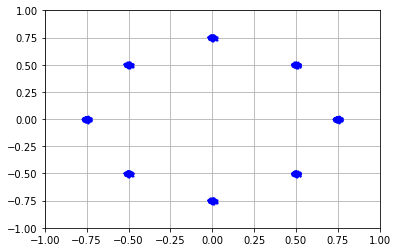

In [5]:
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid(True)

plt.plot(X_train[:,0], X_train[:,1],'bo',markersize=1)

plt.show()
plt.close()

In [6]:
model = WGAN(using_gpu=False)

using : /cpu:0


In [7]:
sess = tf.Session()

In [8]:
model.train(
    X_train=X_train,
    batch_size=50,
    epoch_num=1001,
    critic_step=5,
    sess=sess,
    imgpath='./NormalDist_WGAN_100_noactive_clip001_Adam_crinum5_images/',
    ckptpath='./NormaiDist_WGAN_100_noactive_clip001_Adam_crinum5_checkpoints/',
    log_file='NormalDist_WGAN_100_noactive_clip001_Adam_crinum5_loss_log.csv',
    init=True)

Initialize
[Train] epoch: 0, cri loss: 0.001520 , gen loss : 0.005920  Time : 1.465828
[Train] epoch: 50, cri loss: 0.000102 , gen loss : 0.003917  Time : 1.122514
[Train] epoch: 100, cri loss: 0.000185 , gen loss : 0.004155  Time : 0.992542
[Train] epoch: 150, cri loss: 0.000111 , gen loss : 0.004563  Time : 1.121315
[Train] epoch: 200, cri loss: 0.000104 , gen loss : 0.004383  Time : 1.133049
[Train] epoch: 250, cri loss: 0.000005 , gen loss : 0.004504  Time : 1.104653
[Train] epoch: 300, cri loss: -0.000033 , gen loss : 0.003913  Time : 1.088850
[Train] epoch: 350, cri loss: -0.000017 , gen loss : 0.003855  Time : 0.850031
[Train] epoch: 400, cri loss: 0.000029 , gen loss : 0.003512  Time : 1.074109
[Train] epoch: 450, cri loss: 0.000011 , gen loss : 0.004097  Time : 0.898954
[Train] epoch: 500, cri loss: 0.000129 , gen loss : 0.003302  Time : 0.897845
[Train] epoch: 550, cri loss: 0.000092 , gen loss : 0.003983  Time : 0.996747
[Train] epoch: 600, cri loss: -0.000186 , gen loss : 0

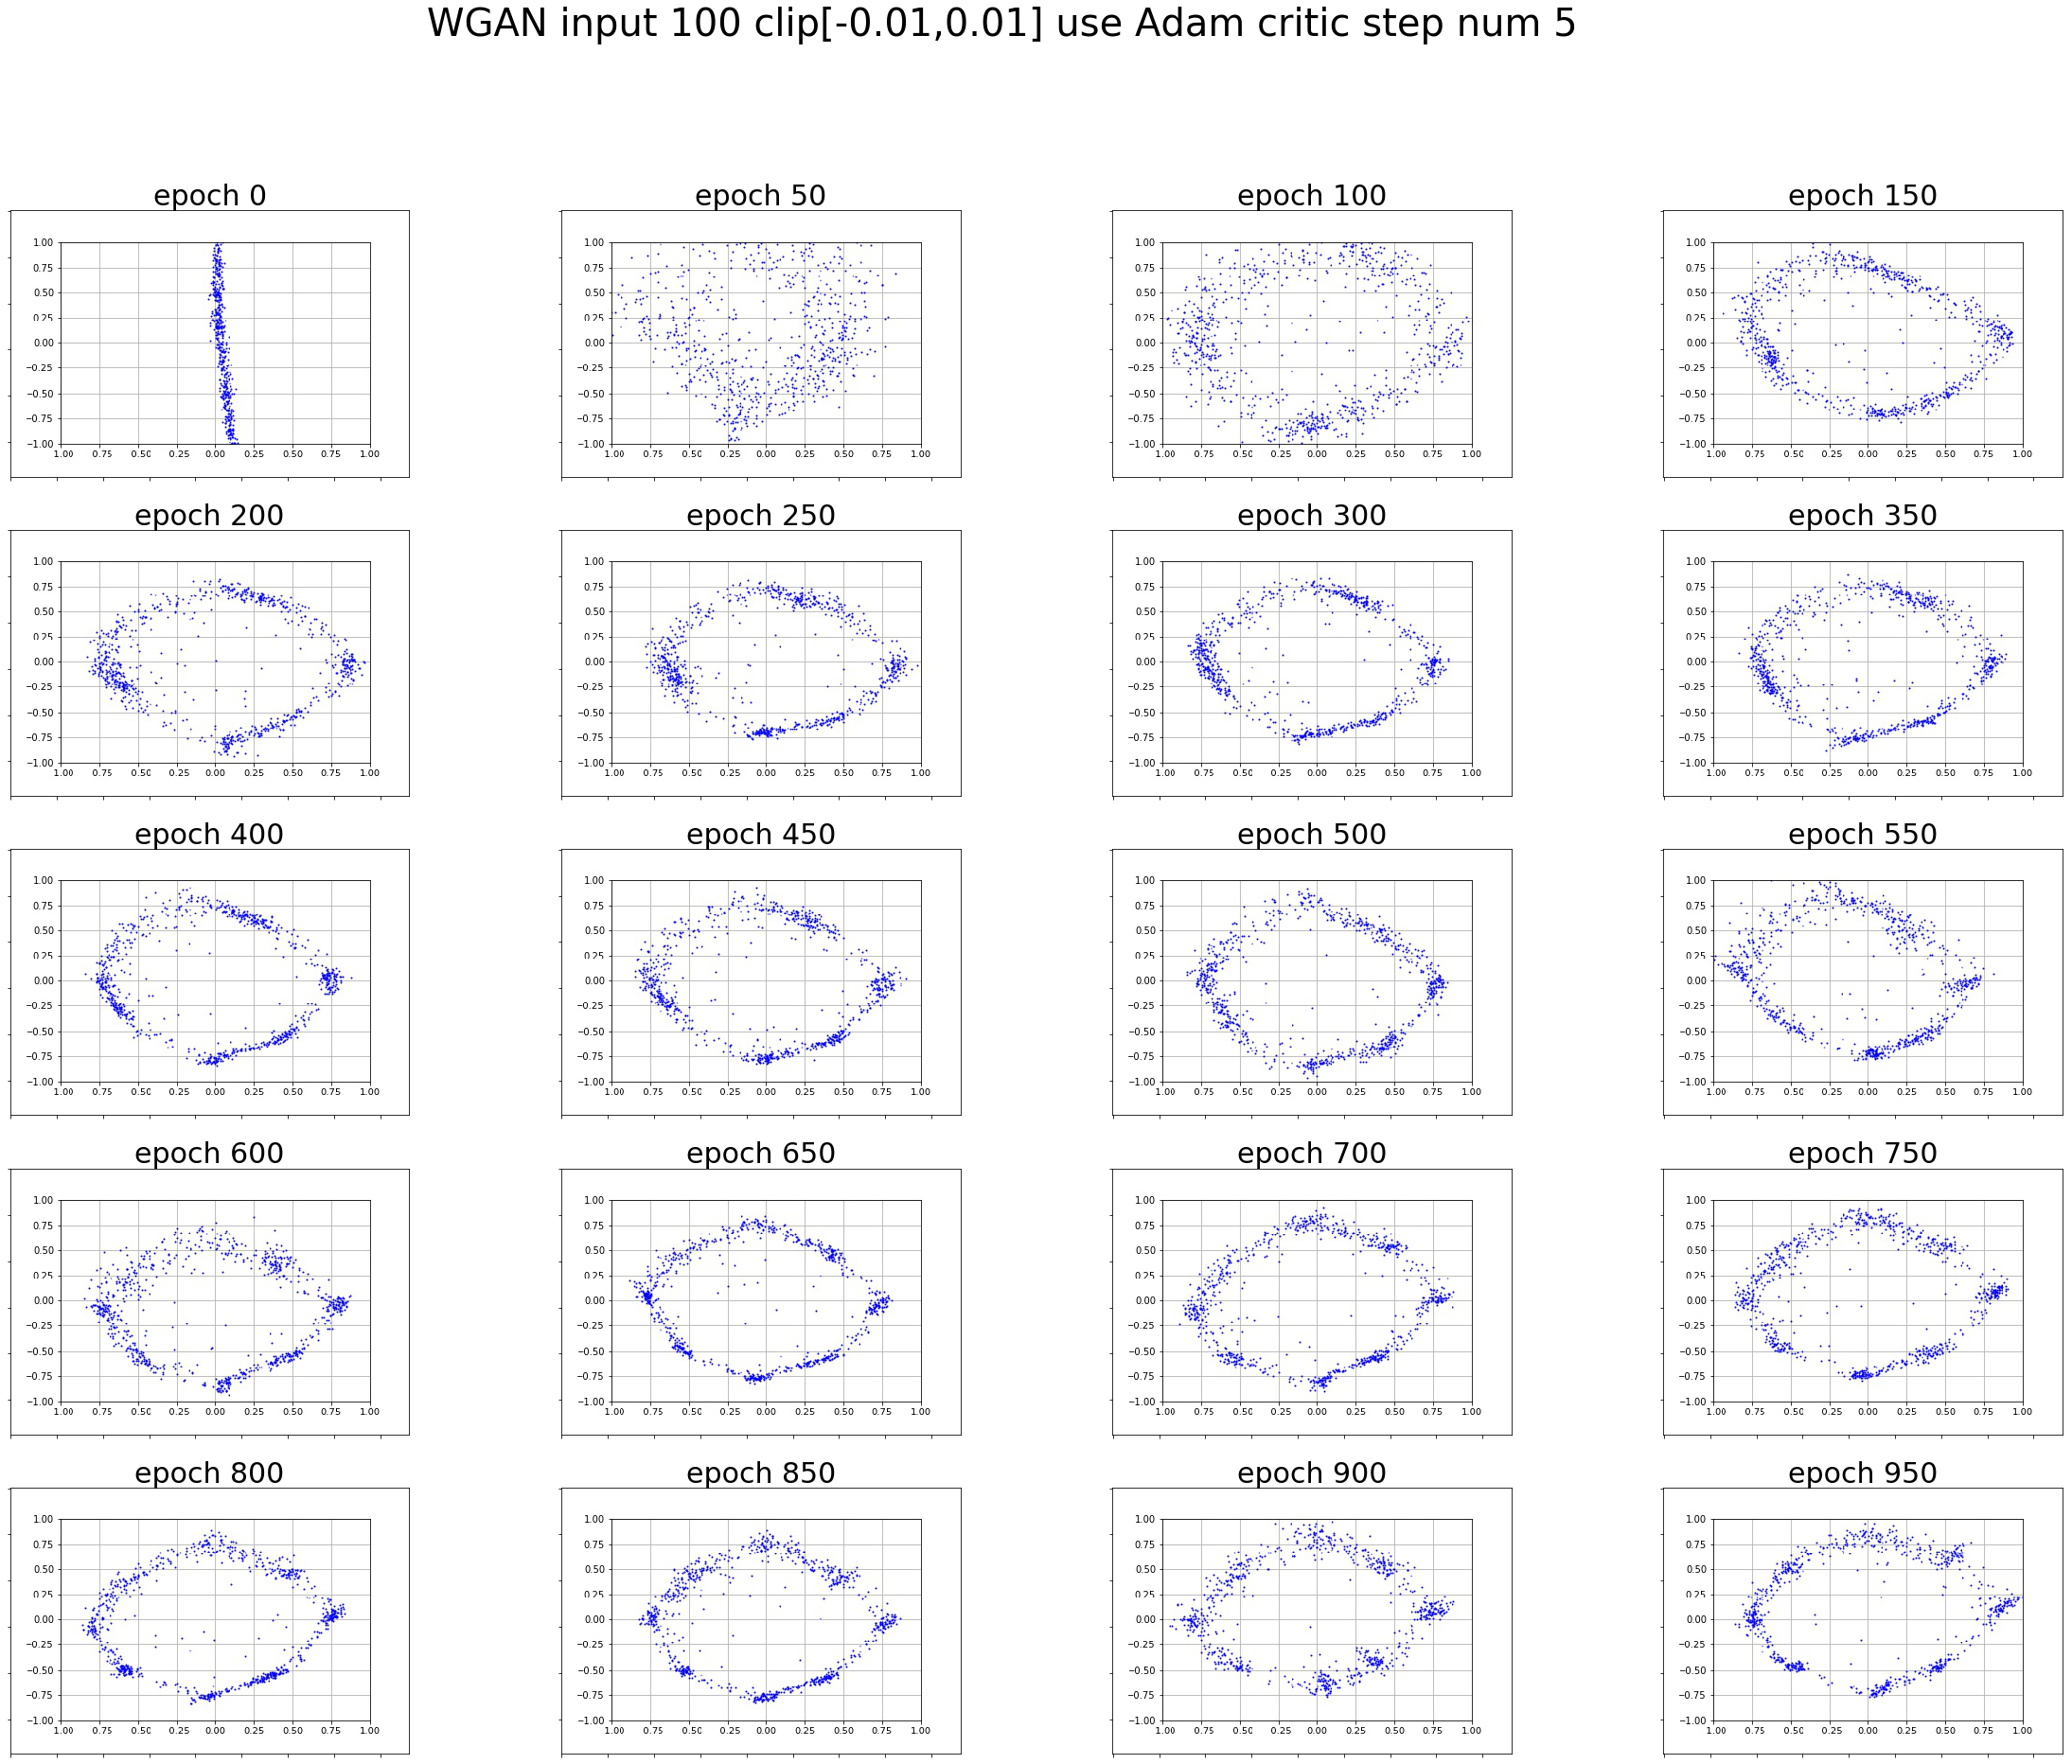

In [9]:
epoch_num = list(range(0,1000,50)) 
plt.figure(figsize=(40,30))
for i,epoch in enumerate(epoch_num):
    img = Image.open('./NormalDist_WGAN_100_noactive_clip001_Adam_crinum5_images/generate_points_epoch{0}.jpg'.format(epoch), 'r')
    # train data plot
    plt.subplot(5, 4, i+1)
    plt.title('epoch {0}'.format(epoch),fontsize=30)
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.imshow(img)

plt.suptitle('WGAN input 100 clip[-0.01,0.01] use Adam critic step num 5',fontsize=40)
plt.show()

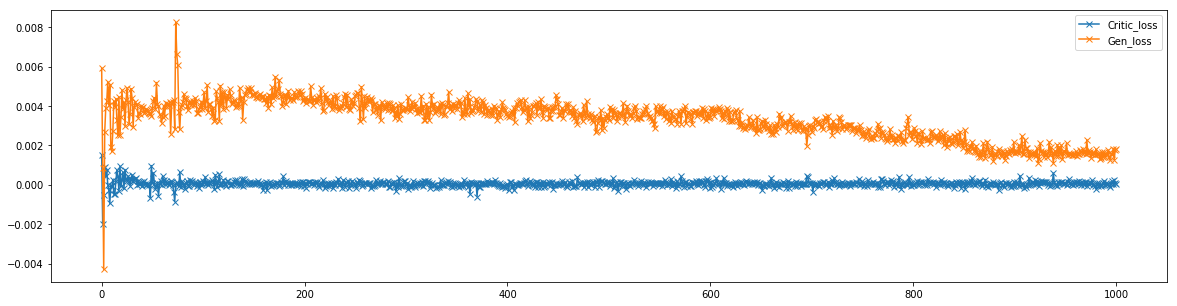

In [10]:
import pandas as pd
df = pd.read_csv('./NormalDist_WGAN_100_noactive_clip001_Adam_crinum5_loss_log.csv', names=['Epoch', 'Critic_loss','Gen_loss'])
plt.figure(figsize=(20, 5))
plt.plot(df['Epoch'],df['Critic_loss'],'-x',label='Critic_loss')
plt.plot(df['Epoch'],df['Gen_loss'],'-x',label='Gen_loss')
plt.legend()
plt.savefig('NormalDist_WGAN_100_noactive_clip001_Adam_crinum5_loss_log.png')
plt.show()
plt.close()